# Understanding the camera calibration process

Use the *Rigid Body Tracking* package and the CoppeliaSim API to understand and analyze the image formation and the camera calibration problem. 

**Objective:** Find the point projection problem using the Coppelia data. 

## Mathematical foundation of the perspective camera

<p align = 'center'>
    <img src = 'Images/image-plane.jpeg'>
</p>

The point $p$ in the image plane is described by:
$$ x = f\frac{X}{Z}$$
$$ y = f\frac{Y}{Z}$$

---

Writing the point $p$ in homogenous coordinates: 
$$ \tilde{x} = fX $$
$$ \tilde{y} = fY $$
$$ \tilde{z} = Z $$

In matrix form: 

$$ \tilde{p} = \begin{pmatrix} f & 0 & 0\\ 0 &f  &0 \\ 0 & 0 &1 \end{pmatrix}
\cdot \begin{pmatrix} X\\ Y\\ Z \end{pmatrix} $$

Where the nonhomogeneous image-plane coordinates are: 

$$ x = \frac{\tilde{x}}{\tilde{z}} $$
$$ y = \frac{\tilde{y}}{\tilde{z}} $$

---

<p align = 'center'>
    <img src = 'Images/camera-pose.jpeg'>
</p>

The world point P need to be written in respect to the camera coordinate frame. The coordinate vector of the world point with respect to the camera frame can be describe as: 

$${^CP}= {^OE_C} \cdot {^OP} $$ 

Where ${^OE_C}$ is the transformation matrix of the world coordinate frame to the camera coordinate frame. This transformation is describe as a rotation and a translation combined. 

---

Now, the perspective projection of a camera is: 

$$ \begin{pmatrix}
\tilde{x}\\ 
\tilde{y}\\ 
\tilde{z}
\end{pmatrix}= \begin{pmatrix}
f & 0 & 0\\ 
0 &f  &0 \\ 
0 & 0 &1 
\end{pmatrix}\cdot 
\begin{pmatrix}
{^CR_O} & {^Ct_O}\\ 
0 & 1
\end{pmatrix}
\begin{pmatrix}
X\\ 
Y\\ 
Z\\
1
\end{pmatrix}$$ 


$$ \tilde{p} = M_{int}\cdot M{ext}\cdot \tilde{P}$$ 

---

Ta faltando o que: (ordem de importância)

- definir o erro da calibração 
- funcao para calcular o erro
- função para minimizar os parâmetros
---

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from cv2 import projectPoints, Rodrigues
from modules.viewer import Viewer
from modules.feed import Feed
from modules.frame import Frame
from modules.rigid import *
from modules.camera import *

from coppeliasim_zmqremoteapi_client import RemoteAPIClient


### 1° Define the references frames and the image plane 

- The rotation and translation of the camera must be the same as in Coppelia

In [74]:
'''# Create the world coordinate frame
world = Frame()

# Start simulation in CoppeliaSim
sim.startSimulation() 

# Get Vision_sensor transformation matrix (R and t related to world coordinate frame)
transformation_matrix = sim.getObjectMatrix(visionSensorHandle, -1)
euler_angles = sim.getEulerAnglesFromMatrix(transformation_matrix) # Euler angles are used just for debug
transformation_matrix = np.array(transformation_matrix).reshape(3,4) # Transform to a 3 x 4 matrix

# Stop simulation in CoppeliaSim
sim.stopSimulation()

# Get the extrinsic parameters of the camera
rotation_matrix, translation_vector = split_homo(transformation_matrix)

# Create the camera frame
camera = Frame(rotation_matrix,translation_vector)

# Define the camera characteristics 
sensor_size = (0.368, 0.274)
focal_dist = 0.304

# Create the image plane - Define the points of this plane
image_plane = crete_image_plane(sensor_size[0],sensor_size[1],transformation_matrix,focal_dist)'''

'# Create the world coordinate frame\nworld = Frame()\n\n# Start simulation in CoppeliaSim\nsim.startSimulation() \n\n# Get Vision_sensor transformation matrix (R and t related to world coordinate frame)\ntransformation_matrix = sim.getObjectMatrix(visionSensorHandle, -1)\neuler_angles = sim.getEulerAnglesFromMatrix(transformation_matrix) # Euler angles are used just for debug\ntransformation_matrix = np.array(transformation_matrix).reshape(3,4) # Transform to a 3 x 4 matrix\n\n# Stop simulation in CoppeliaSim\nsim.stopSimulation()\n\n# Get the extrinsic parameters of the camera\nrotation_matrix, translation_vector = split_homo(transformation_matrix)\n\n# Create the camera frame\ncamera = Frame(rotation_matrix,translation_vector)\n\n# Define the camera characteristics \nsensor_size = (0.368, 0.274)\nfocal_dist = 0.304\n\n# Create the image plane - Define the points of this plane\nimage_plane = crete_image_plane(sensor_size[0],sensor_size[1],transformation_matrix,focal_dist)'

### 2° Generate random world points and see their projections in image plane

In [75]:
'''# Generate random point for scene 
number_of_points = 15
points_in_scene = generate_random_points(number_of_points)

# Reshape for better printing 
print("The random points are: \n", points_in_scene.T.reshape(number_of_points,3))'''

'# Generate random point for scene \nnumber_of_points = 15\npoints_in_scene = generate_random_points(number_of_points)\n\n# Reshape for better printing \nprint("The random points are: \n", points_in_scene.T.reshape(number_of_points,3))'

### 3° Create the ground truth camera intrinsic matrix

In [76]:
'''camera_intrinsics = create_intrinsic_matrix(focal_dist)'''

'camera_intrinsics = create_intrinsic_matrix(focal_dist)'

### Plot the setup

In [77]:
def build_intrinsic_matrix(fov_degrees, resolution):
    fov_radians = np.radians(fov_degrees)

    f_x = resolution[0]/(2*np.tan(fov_radians/2))
    f_y = resolution[1]/(2*np.tan(fov_radians/2))

    o_x = resolution[0]/2
    o_y = resolution[1]/2

    camera_matrix = np.array([[-f_x,   0, o_x, 0],
                              [  0, -f_y, o_y, 0],
                              [  0,    0,   1, 0]])

    return camera_matrix

def build_extrinsic_matrix(vision_sensor_handle):
    camera_pose = np.vstack((np.array(sim.getObjectMatrix(vision_sensor_handle)).reshape((3,4)), np.array([0, 0, 0, 1])))

    return camera_pose

def build_projection_matrix(intrinsic_matrix, extrinsic_matrix):
    projection_matrix = intrinsic_matrix @ inverse_homo(extrinsic_matrix) 

    return projection_matrix

def perspective_projection(points, projection_matrix):
    projected_point = projection_matrix @ points  # Project points to plane
    projected_point /= projected_point[-1]        # Normalize homogeneous coordinates
    projected_point = projected_point[:-1, :]     # Discard the last row
    projected_point = projected_point.astype(int) # Cast as interger
    
    return projected_point

# Declare intrinsic parameters
fov_degrees = 60.0
resolution = (480, 480)

# Generate intrinsic parameters matrix
intrinsic_matrix = build_intrinsic_matrix(fov_degrees, resolution) 

client = RemoteAPIClient()
sim = client.getObject('sim')

# Get the vision sensor handle
vision_sensor_handle = sim.getObject('/Vision_sensor') 

# Generate extrinsic parameters matrix
extrinsic_matrix = build_extrinsic_matrix(vision_sensor_handle)

# Generate perspective projection matrix
projection_matrix = build_projection_matrix(intrinsic_matrix, extrinsic_matrix)

# 3D point to be projected in homogeneous coordinates
points_to_project = to_homo(cube()) # Vertices of a cube

# Change cube position
points_to_project[0] -= 0.25
points_to_project[1] -= 0.25
points_to_project[2] += 1

# Create the Scene Viewer
scene = Viewer('Camera Pose Scene', size = 5)

# Add elements to the scene
scene.add_frame(Frame(), 'World Frame', axis_size=0.2)
scene.add_frame(Frame(*split_homo(extrinsic_matrix)), 'Camera Frame', axis_size=0.2) 
scene.add_points(points_to_project, 'World Points', 'black')

# Plot scene
scene.figure.show(renderer='notebook_connected')

# Project the 3D point with the new pose
projected_points = perspective_projection(points_to_project, projection_matrix)

# Create the image viewer
image = Feed('Camera Image', resolution, graphical=True)

# Adding the projected points to the scene
image.add_points(projected_points, 'Image Point', 'black')

# Plot image
image.figure.show(renderer='notebook_connected')

# Print Results (Compare with simulation!)
print('Projected Points in Pixel Coordinates:')
print(projected_points)

Projected Points in Pixel Coordinates:
[[207 226 250 277 148 159 193 213]
 [100  38 149  92 120  54 174 115]]


# Coppelia Enviroment

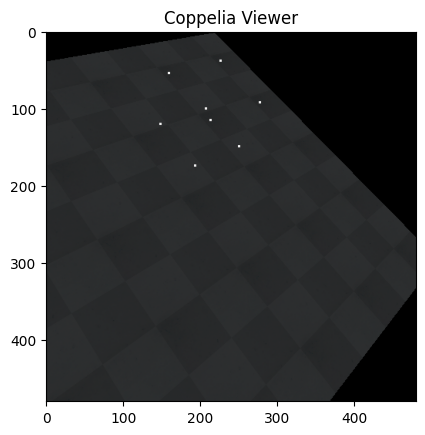

Detected Points in Pixel Coordinates:
[[193 250 148 213 207 277 159 226]
 [174 149 120 115 100  92  54  38]]


In [78]:
# When simulation is not running, ZMQ message handling could be a bit
# slow, since the idle loop runs at 8 Hz by default. So let's make
# sure that the idle loop runs at full speed for this program:
defaultIdleFps = sim.getInt32Param(sim.intparam_idle_fps)   
sim.setInt32Param(sim.intparam_idle_fps, 0)

# Run a simulation in stepping mode:
sim.startSimulation()

point_cloud_handle = sim.createPointCloud(1, 1, 8, 3)
markers_color = list([255,255,255]) 

# Insert points into point cloud
points = np.concatenate(points_to_project[:-1, :].T)

point_count = sim.insertPointsIntoPointCloud(point_cloud_handle, 0, points, markers_color)

coppelia_centroids = None
img = []

# Other blob detection method
while (t := sim.getSimulationTime()) < 1:
    img, resX, resY = sim.getVisionSensorCharImage(vision_sensor_handle)
    img = np.frombuffer(img, dtype=np.uint8).reshape(resY, resX, 3)

    # In CoppeliaSim images are left to right (x-axis), and bottom to top (y-axis)
    # (consistent with the axes of vision sensors, pointing Z outwards, Y up)
    # and color format is RGB triplets, whereas OpenCV uses BGR:
    img = cv2.flip(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), 0)
    
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Convert the grayscale image to binary image
    _,thresh = cv2.threshold(gray_image,230,255,0)

    contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

    for c in contours:
        # Calculate moments of each contour
        M = cv2.moments(c)
        
        # Calculate x,y coordinate of center
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])
        else:
            print('Point not detected!')
            break
        
        centroids = np.array([cX, cY]).reshape(-1,1)

        if coppelia_centroids is None:
            coppelia_centroids = centroids
        else:
            coppelia_centroids = np.hstack((coppelia_centroids, centroids))

    break # Just execute the first loop

# Restore the original idle loop frequency:
sim.setInt32Param(sim.intparam_idle_fps, defaultIdleFps)

sim.stopSimulation()

# Display the image
plt.imshow(img)
plt.title('Coppelia Viewer')
plt.show()

# Print Results (Compare with math model!)
print('Detected Points in Pixel Coordinates:')
print(coppelia_centroids)


### 4° See the image points projections with the ground truth matrix

In [79]:
'''def plot_image_points(image_points):
    """
    Plot the 2D image points

    Parameters
    ----------
    image_points: Array of 2D projected image points.
    """

    if image_points.shape[1] != 2:
        image_points = image_points.reshape(-1,2)
    plt.figure(figsize=(8, 6))
    plt.scatter(image_points[:, 0], image_points[:, 1], c='b', marker='o', label='Pontos Projetados')
    plt.xlabel('Coordenada X na Imagem')
    plt.ylabel('Coordenada Y na Imagem')
    plt.title('Pontos 2D Projetados na Imagem')
    plt.grid()
    plt.legend()
    plt.show()'''

'def plot_image_points(image_points):\n    """\n    Plot the 2D image points\n\n    Parameters\n    ----------\n    image_points: Array of 2D projected image points.\n    """\n\n    if image_points.shape[1] != 2:\n        image_points = image_points.reshape(-1,2)\n    plt.figure(figsize=(8, 6))\n    plt.scatter(image_points[:, 0], image_points[:, 1], c=\'b\', marker=\'o\', label=\'Pontos Projetados\')\n    plt.xlabel(\'Coordenada X na Imagem\')\n    plt.ylabel(\'Coordenada Y na Imagem\')\n    plt.title(\'Pontos 2D Projetados na Imagem\')\n    plt.grid()\n    plt.legend()\n    plt.show()'

In [80]:
'''image_points_cv2 = projectPoints(cube(),rotation_matrix,translation_vector,camera_intrinsics,None)[0]

plot_image_points(image_points=image_points_cv2)

image_points_cv2'''

'image_points_cv2 = projectPoints(cube(),rotation_matrix,translation_vector,camera_intrinsics,None)[0]\n\nplot_image_points(image_points=image_points_cv2)\n\nimage_points_cv2'

In [81]:
'''# Compare projectPoints with my implementation

image_points = project_points(camera_intrinsics,transformation_matrix,cube())
image_points.T'''

'# Compare projectPoints with my implementation\n\nimage_points = project_points(camera_intrinsics,transformation_matrix,cube())\nimage_points.T'

## 5° Calibrate your camera with DLT

In [82]:
'''# Find the camera matrix [ndarray (3,4)] by computing DLT
dlt_camera_matrix = calibrate_camera(cube().T, image_points.T)

# Find K,R and t by RQ factorization
estimated_intrinsic, estimated_r_matrix, estimated_t_vector = extract_camera_parameters(dlt_camera_matrix)

# Create the estimated extrinsic matrix 
estimated_extrinsic = join_homo(estimated_r_matrix,estimated_t_vector.reshape(-1,1))
estimated_extrinsic = estimated_extrinsic[:-1,:]

# Project the world points using the estimated parameters

estimated_image_points = project_points(estimated_intrinsic,estimated_extrinsic,cube())

estimated_image_points
plot_image_points(estimated_image_points)
cube().shape[1]'''

'# Find the camera matrix [ndarray (3,4)] by computing DLT\ndlt_camera_matrix = calibrate_camera(cube().T, image_points.T)\n\n# Find K,R and t by RQ factorization\nestimated_intrinsic, estimated_r_matrix, estimated_t_vector = extract_camera_parameters(dlt_camera_matrix)\n\n# Create the estimated extrinsic matrix \nestimated_extrinsic = join_homo(estimated_r_matrix,estimated_t_vector.reshape(-1,1))\nestimated_extrinsic = estimated_extrinsic[:-1,:]\n\n# Project the world points using the estimated parameters\n\nestimated_image_points = project_points(estimated_intrinsic,estimated_extrinsic,cube())\n\nestimated_image_points\nplot_image_points(estimated_image_points)\ncube().shape[1]'

In [83]:
'''# Find the camera matrix [ndarray (3,4)] by computing DLT
dlt_camera_matrix = calibrate_camera(cube().T, image_points.T)

# Find K,R and t by RQ factorization
estimated_intrinsic, estimated_r_matrix, estimated_t_vector = extract_camera_parameters(dlt_camera_matrix)

# Create the estimated extrinsic matrix 
estimated_extrinsic = join_homo(estimated_r_matrix,estimated_t_vector.reshape(-1,1))
estimated_extrinsic = estimated_extrinsic[:-1,:]

# Project the world points using the estimated parameters

estimated_image_points = project_points(estimated_intrinsic,estimated_extrinsic,cube())

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

for i in range(cube().shape[1]):
    if i == 0:
        o_label = "groundtruth"
        g_label = "predictions"
    else:
        o_label = ""
        g_label = ""
        
    ax.scatter(*image_points.reshape(-1, 2)[i], color="orange", alpha=0.75, label=o_label)
    ax.scatter(*estimated_image_points.reshape(-1, 2)[i], color="green", alpha=0.75, label=g_label)
    
ax.set_title("groundtruth vs predictions - direct linear calibration")
ax.legend()'''


'# Find the camera matrix [ndarray (3,4)] by computing DLT\ndlt_camera_matrix = calibrate_camera(cube().T, image_points.T)\n\n# Find K,R and t by RQ factorization\nestimated_intrinsic, estimated_r_matrix, estimated_t_vector = extract_camera_parameters(dlt_camera_matrix)\n\n# Create the estimated extrinsic matrix \nestimated_extrinsic = join_homo(estimated_r_matrix,estimated_t_vector.reshape(-1,1))\nestimated_extrinsic = estimated_extrinsic[:-1,:]\n\n# Project the world points using the estimated parameters\n\nestimated_image_points = project_points(estimated_intrinsic,estimated_extrinsic,cube())\n\nfig = plt.figure(figsize=(8, 6))\nax = fig.add_subplot(111)\n\nfor i in range(cube().shape[1]):\n    if i == 0:\n        o_label = "groundtruth"\n        g_label = "predictions"\n    else:\n        o_label = ""\n        g_label = ""\n        \n    ax.scatter(*image_points.reshape(-1, 2)[i], color="orange", alpha=0.75, label=o_label)\n    ax.scatter(*estimated_image_points.reshape(-1, 2)[i], 